## Mapper Prime v0.2.2 Demo
In addition to the README, this demo is meant to allow you to easily copy-paste bits of code and get your stuff working. (It also doubles as an integration test.)

In principle, you should be able to drop in your own UMAP data and timestamps, and get a Sankey diagram output. If you want keyword labels then you'll also need to load a list of word bags (see 2nd last cell).

For some explaination of parameters see the included README.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#Normal installed imports
import numpy as np
import pandas as pd
import datamapplot
import sys, os
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
# Local imports (modified versions)
sys.path.append(os.path.relpath("./temporal_grapher"))
import temporal_mapper as tm
import utilities_ as tmutils
import weighted_clustering as tmwc
import fast_hdbscan
sys.path.append(os.path.relpath("./holoviews-main"))
import holoviews as hv
from holoviews import opts, dim
import holoviews.plotting.bokeh
import panel as pn

/work/home/kdrusci/.conda/envs/mapper/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


### Data

In [3]:
data_folder = 'data/'
coordinate_file = 'ai_arxiv_coordinates.npy' # The 2D reduced co-ordinates, can be None
vector_file = 'ai_arxiv_vectors.npy' 
timestamp_file = None # If None, you need to add a cell that pulls these from a dataframe or something. 
vectors = np.load(data_folder+vector_file)
y_data = PCA(n_components = 1).fit_transform(vectors)
N_data = np.size(y_data)
print("Loaded",N_data,"data points.")
if coordinate_file:
    map_data = np.load(data_folder+coordinate_file)
else:
    map_data = UMAP(n_components=2, verbose=True).fit_transform(vectors)

if timestamp_file:
    timestamps = np.load(data_folder+timestamp_file)
else:
    print("Do not forget to add a cell and make an array of timestamps.")


Loaded 10000 data points.
Do not forget to add a cell and make an array of timestamps.


In [4]:
## Making Timestamps
arxiv_df = pd.read_feather(data_folder+'ai_arxiv_data.feather')
# Compute a time column T which is the number of days since Jan 01, 2018.
def date_to_T(date):
    year = date.year
    ## 2020 was a leap year
    if year > 2020:
        return date.timetuple().tm_yday + 365*(year-2018)+1
    else:
        return date.timetuple().tm_yday + 365*(year-2018)

arxiv_df["date"] = pd.to_datetime(arxiv_df["created"])
arxiv_df["T"] = arxiv_df["date"].apply(
    lambda x: date_to_T(x)
)

timestamps = np.array(arxiv_df["T"].to_list())


In [5]:
## Removing duplicate papers 
_, unique_idx = np.unique(arxiv_df['title'], return_index=True)
unique_idx
map_data = map_data[unique_idx]
timestamps = timestamps[unique_idx]
y_data = y_data[unique_idx]
vectors = vectors[unique_idx]
N_data = np.size(y_data)

### Mapper
In theory, if everything works ok, you should be able to just run the following cells without modification.

In [13]:
clusterer = fast_hdbscan.HDBSCAN(min_cluster_size=50)
N_checkpoints = 10
TG = tm.TemporalGraph(
    timestamps,
    map_data,
    clusterer,
    N_checkpoints = N_checkpoints,
    resolution = 50,
    slice_method='data',
    rate_sensitivity=1,
    kernel=tmwc.gaussian,
    #kernel_params=(1,),
    verbose=True
)
clusters = TG._cluster()
y_pts = tm.compute_cluster_yaxis(clusters, y_data)
TG.build(y_pts)


Computing epsilon balls...
Computing spatial density...


Computing f-rates: 5530it [00:00, 14491.91it/s]


Clustering at each time slice...


Converting clusters to vertices: 100%|██████████| 10/10 [00:00<00:00, 11878.52it/s]


23 vertices added.


Adding edges: 100%|██████████| 9/9 [00:00<00:00, 580.84it/s]


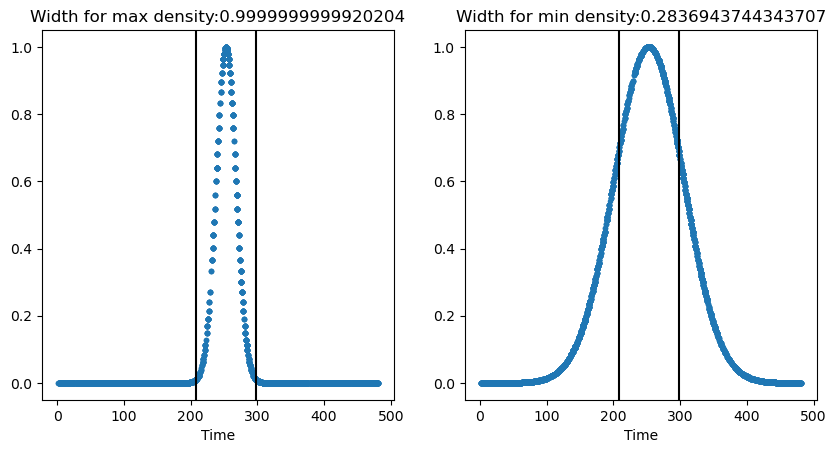

In [14]:
# Plotting the Clustering weight function
t0=np.median(timestamps)
dmin = np.amin(TG.density)
dmax = np.amax(TG.density)
cp_with_ends = [np.amin(timestamps)]+list(TG.checkpoints)+[np.amax(timestamps)]
bin_width = (cp_with_ends[1]-cp_with_ends[0])

fig, (ax1,ax2) = plt.subplots(1,2)
fig.set_figwidth(10)
ax1.set_title("Width for max density:"+str(dmax))
ax1.scatter(timestamps,TG.kernel(t0,timestamps,dmax,bin_width),marker='.')
ax1.set_xlabel("Time")

ax2.scatter(timestamps,TG.kernel(t0,timestamps,dmin,bin_width),marker='.')
ax2.set_title("Width for min density:"+str(dmin))
ax2.set_xlabel("Time")
for ax in (ax1,ax2):
    ax.axvline(t0+bin_width/2,c='k')
    ax.axvline(t0-bin_width/2,c='k')
plt.show()

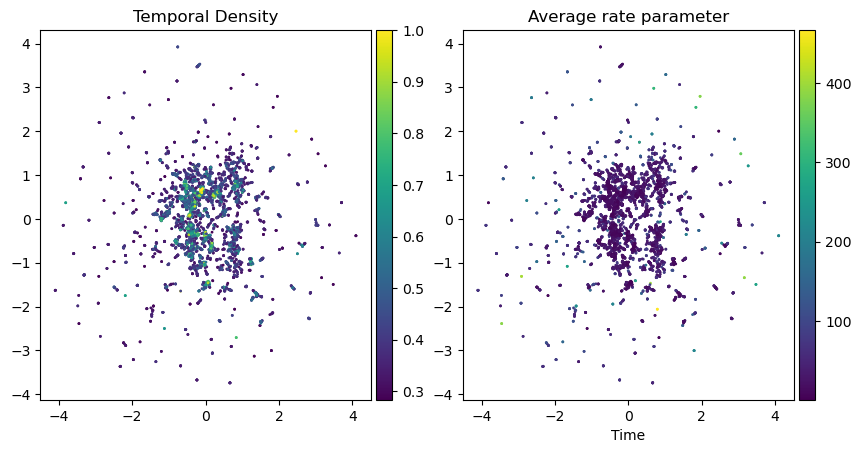

In [15]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, (ax1,ax2) = plt.subplots(1,2)
fig.set_figwidth(10)
ax1.set_title("Temporal Density")
sca=ax1.scatter(map_data[:,0], map_data[:,1],s=1,c=TG.density)
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(sca, cax=cax, orientation='vertical')

rates = TG.rate
iso_idx = (rates==np.inf)
rates[iso_idx]=np.amax(rates)
divider = make_axes_locatable(ax2)
sca2=ax2.scatter(map_data[:,0], map_data[:,1],s=1,c=rates)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(sca2, cax=cax, orientation='vertical')
ax2.set_xlabel("Time")
ax2.set_title("Average rate parameter")
plt.show()

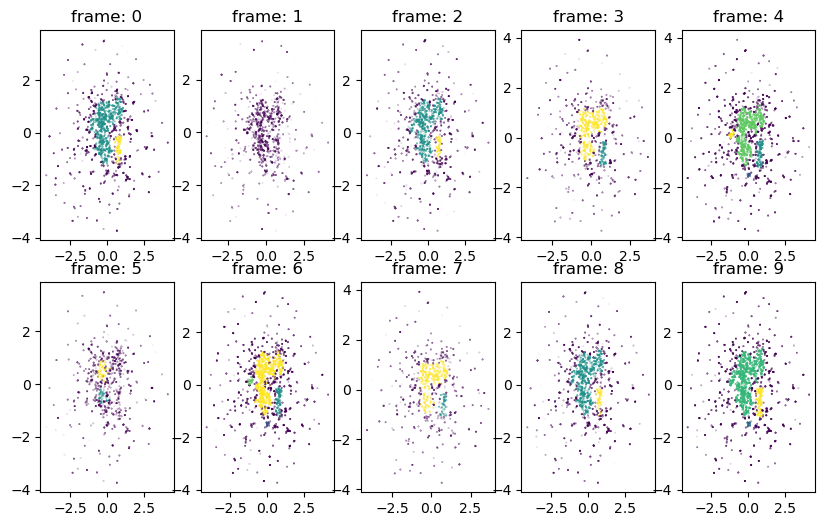

In [16]:
## Plotting what the clustering is at each checkpoint
weights = TG.weights
fig, axes = plt.subplots(2, N_checkpoints//2)
fig.set_figwidth(10)
fig.set_figheight(6)
axes = axes.reshape(N_checkpoints)
for k, slice_ in enumerate(TG.clusters):
    idx = (slice_ != -2).nonzero()[0]
    axes[k].set_title("frame: "+str(k))
    axes[k].scatter(map_data[idx,0],map_data[idx,1],alpha=weights[k,idx],c=slice_[idx],s=0.1)
plt.show()

### Modified Holoviews Sankey

In [ ]:
## Finding keywords for labels
concat = arxiv_df.title[unique_idx] + " " +arxiv_df.abstract[unique_idx]
split = concat.str.split()
list_of_word_bags = split.to_list()
TG=tmutils.generate_keyword_labels(list_of_word_bags, TG, n_words=3, sep='\n')

In [ ]:
hv.extension('bokeh')

## This gives you the entire graph, which is usually too much to look at.
G = TG.G
## You can instead plot just a subgraph:
## This only works the 2nd time you run this cell btw
#name_to_number = nx.get_node_attributes(TG.G, 'index')
#number_to_name = {v: k for k, v in name_to_number.items()}
#vertices = TG.vertex_subgraph(number_to_name[0])
#G = TG.G.subgraph(vertices)

## Use datamapplot's colour features
map_locations = nx.get_node_attributes(TG.G, "pos")
raw_map_locations = np.asarray(list(map_locations.values()))
colours = np.array(datamapplot.palette_handling.palette_from_datamap(map_data, map_data))
node_colours = []
cnt=0
for node in TG.G.nodes():
    idx = TG.get_vertex_data(node,ghost=True)
    values, counts = np.unique(colours[idx], return_counts=True)
    most_ = values[np.argmax(counts)]
    node_colours.append(most_)

node_palette = dict(zip(map_locations.keys(), node_colours))
nx.set_node_attributes(TG.G, node_palette, "colour")

## Convert networkx graph to the holoviews format
nodes, edges, cmap= tm.graph_to_holoviews(G, hv.Dataset) 

sankeyDiagram = hv.Sankey(
    (edges, nodes),
    ['From', 'To'],
)
sankeyDiagram.opts(
    opts.Sankey(labels='label',
                label_position='right',
                width=900,
                height=600,
                cmap=cmap,
                edge_color=dim('To').str(),
               ))

sankeyDiagram